
Total expectation value ⟨σ⟩ at time t = 102.5: -15.211007259375647


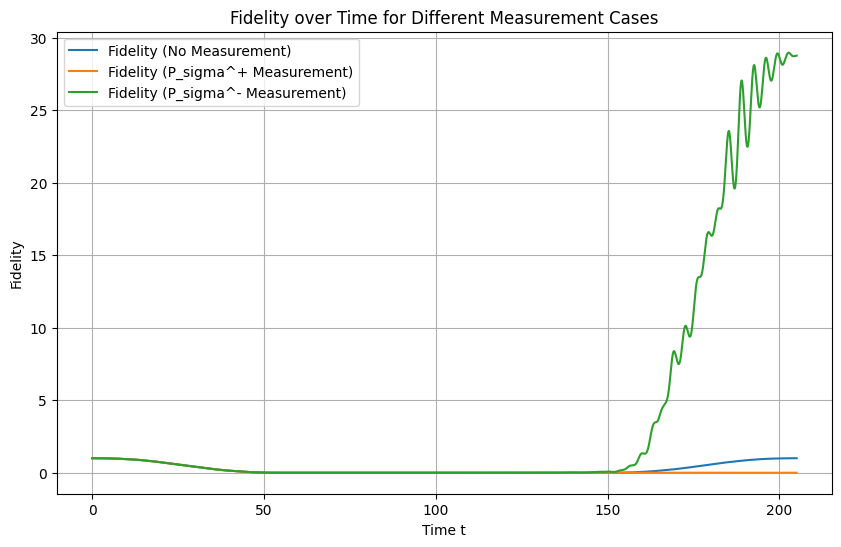

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定数
a = 1.0    # 格子定数
ℏ = 1.0    # プランク定数
N = 20     # スピンの数（偶数）
g_1 = 1.0  # ドライバーハミルトニアンの磁場の強さ
g_2 = 0.2  # 問題ハミルトニアンの磁場の強さ

def make_Hamiltonian_per_k(J, Jg, a, k):
    # ハミルトニアン作成関数
    Driver_Hamiltonian = -2 * Jg * g_1 * (np.identity(2)-np.array([[0, 0], [0, 1]]))
    Problem_Hamiltonian = 2 * J * (-np.cos(k * a) * np.array([[0, 0], [0, 1]]) + np.sin(k * a) * np.array([[0, 1], [1, 0]]) + g_2 * (np.identity(2)-np.array([[0, 0], [0, 1]])))
    return  Driver_Hamiltonian + Problem_Hamiltonian

def get_k_values(N, a):
    # 波数 k
    n_values = range(N // 2)
    k_values_positive = []
    for n in n_values:
        k_value = (2 * np.pi / (N * a)) * (n + 0.5)
        k_values_positive.append(k_value)
    k_values = np.array(k_values_positive) 
    return k_values

def rungekutta_first_order(f, t0, x0, te, h):
    # 1階の微分方程式を解くための4次ルンゲクッタ法
    ts = np.arange(t0, te + h, h)
    xs = []
    x = x0.copy()
    for t in ts:
        xs.append(x)
        k1 = h * f(t, x)
        k2 = h * f(t + h / 2, x + k1 / 2)
        k3 = h * f(t + h / 2, x + k2 / 2)
        k4 = h * f(t + h, x + k3)
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return ts, np.array(xs)

# 新しい時間パラメータ
T = 100     # 元の te と同じ
T_prime = 5  # 適切な値を設定します

# 初期状態
ψ0 = np.array([1, 0], dtype=complex)

# 初期時刻と終了時刻
t0 = 0
te = 2 * T + T_prime  # シミュレーションの終了時刻を更新

# ステップ幅
h = 0.01     

# A_EMQA(t) と B_EMQA(t) の定義
def A_EMQA(t):
    A_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    A_t[cond1] = - (t[cond1] / T) + 1
    A_t[cond2] = 0
    A_t[cond3] = - (t[cond3] / T) + (T_prime / T) + 1
    return A_t

def B_EMQA(t):
    B_t = np.zeros_like(t)
    cond1 = (t >= 0) & (t <= T)
    cond2 = (t > T) & (t <= T + T_prime)
    cond3 = (t > T + T_prime) & (t <= 2 * T + T_prime)
    B_t[cond1] = t[cond1] / T
    B_t[cond2] = - (2 * t[cond2] / T_prime) + (2 * T / T_prime) + 1
    B_t[cond3] = (t[cond3] / T) - (T_prime / T) - 2
    return B_t

# k 値を取得
k_values = get_k_values(N, a)

# 時間配列を作成
ts = np.arange(t0, te + h, h)

# 測定時刻
t_m = T + T_prime / 2

# 時刻インデックスを計算
idx_t_m = int((t_m - t0) / h)

# ケース1：測定なし
psi_k_array_no_measurement = []

for k in k_values:
    # シュレディンガー方程式を定義
    def f_Schrodinger_equation(t, ψ):
        Jg = A_EMQA(np.array([t]))[0]
        J = B_EMQA(np.array([t]))[0]
        H_k = make_Hamiltonian_per_k(J, Jg, a, k)
        return -1j * np.dot(H_k, ψ) / ℏ

    # シュレディンガー方程式を解く
    _, ψs = rungekutta_first_order(f_Schrodinger_equation, t0, ψ0, te, h)

    # 結果を保存
    psi_k_array_no_measurement.append(ψs)

# ケース2：\( P_{\sigma}^+ \) を適用
psi_k_array_with_measurement_plus = []

for k in k_values:
    # シュレディンガー方程式を定義（同じ）
    def f_Schrodinger_equation(t, ψ):
        Jg = A_EMQA(np.array([t]))[0]
        J = B_EMQA(np.array([t]))[0]
        H_k = make_Hamiltonian_per_k(J, Jg, a, k)
        return -1j * np.dot(H_k, ψ) / ℏ

    # t0 から t_m まで時間発展
    ts1, ψs1 = rungekutta_first_order(f_Schrodinger_equation, t0, ψ0, t_m, h)

    # t_m における状態を取得
    psi_k_t_m = ψs1[-1]

    # 問題ハミルトニアンのパウリ演算子を定義
    sigma_problem =  2 * (np.cos(k * a)) * np.array([[0, 0], [0, 1]]) \
                     + 2 * np.sin(k * a) * np.array([[0, 1], [1, 0]])

    # 単位行列
    I = np.identity(2, dtype=complex)

    # 測定演算子 \( P_{\sigma}^+ \)
    P_sigma_plus = 0.5 * (I + sigma_problem)

    # 射影測定を適用
    psi_k_t_m_plus = np.dot(P_sigma_plus, psi_k_t_m)


    # t_m から te まで再度時間発展
    ts2, ψs2 = rungekutta_first_order(f_Schrodinger_equation, t_m, psi_k_t_m_plus, te, h)

    # 全体の時間発展を結合
    ψs_full = np.vstack((ψs1, ψs2[1:]))

    # 結果を保存
    psi_k_array_with_measurement_plus.append(ψs_full)

# ケース3：\( P_{\sigma}^- \) を適用
psi_k_array_with_measurement_minus = []

for k in k_values:
    # シュレディンガー方程式を定義（同じ）
    def f_Schrodinger_equation(t, ψ):
        Jg = A_EMQA(np.array([t]))[0]
        J = B_EMQA(np.array([t]))[0]
        H_k = make_Hamiltonian_per_k(J, Jg, a, k)
        return -1j * np.dot(H_k, ψ) / ℏ

    # t0 から t_m まで時間発展
    ts1, ψs1 = rungekutta_first_order(f_Schrodinger_equation, t0, ψ0, t_m, h)

    # t_m における状態を取得
    psi_k_t_m = ψs1[-1]

    # 問題ハミルトニアンのパウリ演算子を定義（同じ）
    sigma_problem =  2 * (np.cos(k * a)) * np.array([[0, 0], [0, 1]]) \
                     + 2 * np.sin(k * a) * np.array([[0, 1], [1, 0]])

    # 単位行列
    I = np.identity(2, dtype=complex)

    # 測定演算子 \( P_{\sigma}^- \)
    P_sigma_minus = 0.5 * (I - sigma_problem)

    # 射影測定を適用
    psi_k_t_m_minus = np.dot(P_sigma_minus, psi_k_t_m)

    # t_m から te まで再度時間発展
    ts2, ψs2 = rungekutta_first_order(f_Schrodinger_equation, t_m, psi_k_t_m_minus, te, h)

    # 全体の時間発展を結合
    ψs_full = np.vstack((ψs1, ψs2[1:]))

    # 結果を保存
    psi_k_array_with_measurement_minus.append(ψs_full)

# リストを配列に変換
psi_k_array_no_measurement = np.array(psi_k_array_no_measurement)
psi_k_array_with_measurement_plus = np.array(psi_k_array_with_measurement_plus)
psi_k_array_with_measurement_minus = np.array(psi_k_array_with_measurement_minus)

# フィデリティの計算とプロットを行う（3つのケース）

# 期待値の計算

expectation_value_total = 0

for idx_k, k in enumerate(k_values):
    # 測定なしの場合の最終状態（分母用）
    psi_k_no_meas = psi_k_array_no_measurement[idx_k, -1, :]
    
    # 測定前の状態（時刻 t_m の状態）
    psi_k_t_m = psi_k_array_no_measurement[idx_k, idx_t_m, :]
    
    # 問題ハミルトニアンのパウリ演算子を定義
    sigma_problem =  2 * (np.cos(k * a)) * np.array([[0, 0], [0, 1]]) \
                     + 2 * np.sin(k * a) * np.array([[0, 1], [1, 0]])
    
    # 単位行列
    I = np.identity(2, dtype=complex)
    
    # 測定演算子 \( P_{\sigma}^+ \) と \( P_{\sigma}^- \)
    P_sigma_plus = 0.5 * (I + sigma_problem)
    P_sigma_minus = 0.5 * (I - sigma_problem)
    
    # 射影測定の確率を計算
    prob_plus = np.abs(np.vdot(psi_k_t_m, np.dot(P_sigma_plus, psi_k_t_m)))**2
    prob_minus = np.abs(np.vdot(psi_k_t_m, np.dot(P_sigma_minus, psi_k_t_m)))**2
    
    # 分子の計算：\( P^+ - P^- \)
    numerator_k = prob_plus - prob_minus
    
    # 分母の計算（測定なしの最終状態のノルムの二乗、通常は1）
    denominator_k = np.vdot(psi_k_no_meas, psi_k_no_meas).real
    
    # 各 k に対する期待値を計算
    if denominator_k != 0:
        expectation_value_k = numerator_k / denominator_k
    else:
        expectation_value_k = 0  # 分母がゼロの場合はゼロとする
    
    # 期待値を合計
    expectation_value_total += expectation_value_k

print(f"\nTotal expectation value ⟨σ⟩ at time t = {t_m}: {expectation_value_total}")

# フィデリティを保存するリストを初期化
fidelity_no_measurement = []
fidelity_with_measurement_plus = []
fidelity_with_measurement_minus = []

for idx_t, t in enumerate(ts):
    # フィデリティ（測定なし）
    fidelity_k_no_meas = []
    for idx_k, k in enumerate(k_values):
        psi_k_t = psi_k_array_no_measurement[idx_k, idx_t, :]
        fidelity_k = np.abs(np.vdot(ψ0, psi_k_t))**2
        fidelity_k_no_meas.append(fidelity_k)
    # 各 k に対するフィデリティの積を計算
    total_fidelity_no_meas = np.prod(fidelity_k_no_meas)
    fidelity_no_measurement.append(total_fidelity_no_meas)

    # フィデリティ（測定あり、P_sigma_plus）
    fidelity_k_with_meas_plus = []
    for idx_k, k in enumerate(k_values):
        psi_k_t = psi_k_array_with_measurement_plus[idx_k, idx_t, :]
        fidelity_k = np.abs(np.vdot(ψ0, psi_k_t))**2
        fidelity_k_with_meas_plus.append(fidelity_k)
    total_fidelity_with_meas_plus = np.prod(fidelity_k_with_meas_plus)
    fidelity_with_measurement_plus.append(total_fidelity_with_meas_plus)

    # フィデリティ（測定あり、P_sigma_minus）
    fidelity_k_with_meas_minus = []
    for idx_k, k in enumerate(k_values):
        psi_k_t = psi_k_array_with_measurement_minus[idx_k, idx_t, :]
        fidelity_k = np.abs(np.vdot(ψ0, psi_k_t))**2
        fidelity_k_with_meas_minus.append(fidelity_k)
    total_fidelity_with_meas_minus = np.prod(fidelity_k_with_meas_minus)
    fidelity_with_measurement_minus.append(total_fidelity_with_meas_minus)

# フィデリティのプロット
plt.figure(figsize=(10, 6))
plt.plot(ts, fidelity_no_measurement, label='Fidelity (No Measurement)')
plt.plot(ts, fidelity_with_measurement_plus, label='Fidelity (P_sigma^+ Measurement)')
plt.plot(ts, fidelity_with_measurement_minus, label='Fidelity (P_sigma^- Measurement)')
plt.xlabel('Time t')
plt.ylabel('Fidelity')
plt.title('Fidelity over Time for Different Measurement Cases')
plt.legend()
plt.grid(True)
plt.show()


H_pに横磁場を加えてみる
初期がh=1で最終h=0.2にして示す
zだけだとオールupかオールダウンor非断熱遷移のもの
符号も任せてやる

リンドブラッド方程式を修正する
L_k=c_k†c_k+c_{-k}^†c_{-k}
これを実空間で考えると全部がひっくり返るようなノイズになる
|01>と|10>も基底に入ってくる？